In [157]:
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image
import os
import xml.etree.ElementTree as ET

class PotholeDatasetFromProposals(Dataset):
    def __init__(self, file_list, img_dir, proposals, transform=None, target_ratio=7.0, apply_ratio=False):
        """
        Initialize the Pothole dataset using only the proposals JSON.
        
        Args:
            file_list (list): List of image filenames.
            img_dir (str): Directory where images are stored.
            proposals (dict): Proposed bounding boxes and labels for each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.transform = transform

        if apply_ratio:
            # Apply ratio to achieve some class balance
            self.samples = []
            for img_name in file_list:
                background_proposals = [proposal for proposal in proposals.get(img_name, []) if proposal['label'] == 'background']
                pothole_proposals = [proposal for proposal in proposals.get(img_name, []) if proposal['label'] == 'pothole']

                # Sample pothole proposals to match the background proposals
                num_background = len(background_proposals)
                num_potholes = len(pothole_proposals)

                if num_potholes == 0:
                    boxes = self._add_from_xml(img_name)
                    pothole_proposals = boxes
                    num_potholes = len(boxes)
                
                #required background count should be the compliment of the ratio, so if there are 3 potholes, and the ratio is 0.3 then the required background count should be 7
                required_background_count = int(num_potholes * (( 1 / target_ratio ) - 1 ))
                required_background_count = min(num_background, required_background_count)

                for proposal in pothole_proposals:
                    self.samples.append({
                        "img_name": img_name,
                        "bbox": proposal,
                    })
                
                #get random background proposals to match the required count                
                background_boxes = random.sample(background_proposals, required_background_count)
                for proposal in background_boxes:
                    self.samples.append({
                        "img_name": img_name,
                        "bbox": proposal,
                    })

        else:
            # Flatten the dataset to treat each bounding box as an independent sample
            self.samples = []
            for img_name in file_list:
                for proposal in proposals.get(img_name, []):
                    self.samples.append({
                        "img_name": img_name,
                        "bbox": proposal,
                    })

    def __len__(self):
        return len(self.samples)
    
    def _add_from_xml(self, img_name):
        # Same as before, no modification needed
        boxes = []
        xml_file = img_name.replace('.jpg', '.xml')
        tree = ET.parse(os.path.join(self.img_dir, xml_file))
        root = tree.getroot()
        for obj in root.findall("object"):
            if obj.find("name").text == "pothole":
                bbox = obj.find("bndbox")
                xmin, ymin, xmax, ymax = map(int, (bbox.find("xmin").text, bbox.find("ymin").text, bbox.find("xmax").text, bbox.find("ymax").text))
                box = {
                    "x": xmin,
                    "y": ymin,
                    "width": xmax - xmin,
                    "height": ymax - ymin,
                    "label": "pothole",
                }
                boxes.append(box)
        return boxes
        

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_name = sample["img_name"]
        bbox = sample["bbox"]

        if not self.samples[idx].get("crop"):      
            # Load and crop the image to the bounding box region
            image_path = os.path.join(self.img_dir, img_name)
            image = Image.open(image_path).convert("RGB")

            # Original bounding box coordinates
            x, y, width, height = (
                bbox["x"],
                bbox["y"],
                bbox["width"],
                bbox["height"]
            )

            # Crop the image to the bounding box
            cropped_image = image.crop((x, y, x + width, y + height))
            self.samples[idx]["crop"] = cropped_image
        
        cropped_image = self.samples[idx]["crop"]
        # Apply transformations to the cropped region
        if self.transform:
            cropped_image = self.transform(cropped_image)
        
        # Determine label
        label = 0 if bbox['label'] == "background" else 1  # 0 for "background", 1 for "pothole"
        
        return cropped_image, label

In [158]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces to 64x64
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Reduces to 32x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # Reduces to 16x16
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust the in_features based on image size after convolutions
        self.fc2 = nn.Linear(128, 2)  # Output layer for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [159]:
import json

home_dir = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3' # Update with the actual path

# Load the labeled proposals (assumed to be in the JSON format as described)
proposals = None
proposal_file_path = f'{home_dir}/labeled_proposals_edge_boxes.json'
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)


In [160]:
from sklearn.model_selection import train_test_split

file_list = list(proposals.keys())  # Image files in the proposals
img_dir = f'{home_dir}/Potholes/annotated-images' 

transform_train= T.Compose([
    T.RandomHorizontalFlip(),  # Randomly flip the image vertically
    T.RandomRotation(10),  # Randomly rotate the image by 20 degrees
    T.Resize((128, 128)),  # Resize to 128x128
    T.ToTensor(),  # Convert to tensor
])

transform = T.Compose([
    T.Resize((128, 128)),  # Resize to 128x128
    T.ToTensor(),  # Convert to tensor
])

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the training data into training and validation sets
train_files, test_files = train_test_split(file_list, test_size=test_ratio + val_ratio, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of test images: {len(test_files)}")

# Define the datasets using the split files
train_dataset = PotholeDatasetFromProposals(
    file_list=train_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform_train,
    target_ratio=0.5,  # 30% potholes, 70% background
    apply_ratio=True
)

val_dataset = PotholeDatasetFromProposals(
    file_list=val_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform,
    target_ratio=0.5,  # 30% potholes, 70% background
    apply_ratio=True
)

test_dataset = PotholeDatasetFromProposals(
    file_list=test_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform,
    target_ratio=0.5,  # 30% potholes, 70% background
    apply_ratio=True
)


Number of training images: 465
Number of validation images: 100
Number of test images: 100


In [161]:
from torch.utils.data import DataLoader

# Data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

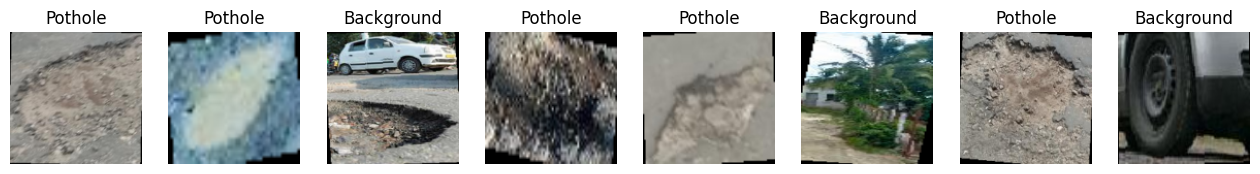

In [162]:
# Display the first batch of images
images, targets = next(iter(train_loader))
#plot the images in the batch, along with the corresponding labels
import matplotlib.pyplot as plt
import numpy as np

#plot background and plot hole images
fig, axs = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title("Pothole" if targets[i] == 1 else "Background")
plt.show()


In [163]:
#calculate class imbalance
def calculate_class_imbalance(dataset):
    samples = dataset.samples
    background_count = sum(1 for sample in samples if sample["bbox"]["label"] == "background")
    pothole_count = sum(1 for sample in samples if sample["bbox"]["label"] == "pothole")

    print(f"Number of background samples: {background_count}")
    print(f"Number of pothole samples: {pothole_count}")
    
    total_samples = len(samples)
    print(f"Ratio of potholes: {pothole_count / total_samples:.2f}")
    print(f"Ratio of background: {background_count / total_samples:.2f}")

print("Training set:")
calculate_class_imbalance(train_dataset)

print("\nValidation set:")
calculate_class_imbalance(val_dataset)

print("\nTest set:")
calculate_class_imbalance(test_dataset)


Training set:
Number of background samples: 2862
Number of pothole samples: 2862
Ratio of potholes: 0.50
Ratio of background: 0.50

Validation set:
Number of background samples: 583
Number of pothole samples: 583
Ratio of potholes: 0.50
Ratio of background: 0.50

Test set:
Number of background samples: 652
Number of pothole samples: 652
Ratio of potholes: 0.50
Ratio of background: 0.50


In [164]:
USE_LOCAL_MODEL = False

Epoch [1/40], Loss: 0.6902, Accuracy: 0.5856
Validation Loss: 0.6222, Validation Accuracy: 0.6725
Epoch [2/40], Loss: 0.6387, Accuracy: 0.6490
Validation Loss: 1.0156, Validation Accuracy: 0.5092
Epoch [3/40], Loss: 0.6279, Accuracy: 0.6595
Validation Loss: 0.7162, Validation Accuracy: 0.5897
Epoch [4/40], Loss: 0.6150, Accuracy: 0.6731
Validation Loss: 0.6360, Validation Accuracy: 0.6472
Epoch [5/40], Loss: 0.6081, Accuracy: 0.6747
Validation Loss: 0.6854, Validation Accuracy: 0.5767
Epoch [6/40], Loss: 0.5885, Accuracy: 0.6904
Validation Loss: 0.6900, Validation Accuracy: 0.6212
Epoch [7/40], Loss: 0.5770, Accuracy: 0.7034
Validation Loss: 0.5466, Validation Accuracy: 0.7232
Epoch [8/40], Loss: 0.5667, Accuracy: 0.7084
Validation Loss: 0.5129, Validation Accuracy: 0.7646
Epoch [9/40], Loss: 0.5493, Accuracy: 0.7261
Validation Loss: 0.5240, Validation Accuracy: 0.7354
Epoch [10/40], Loss: 0.5470, Accuracy: 0.7280
Validation Loss: 0.5429, Validation Accuracy: 0.7362
Epoch [11/40], Loss

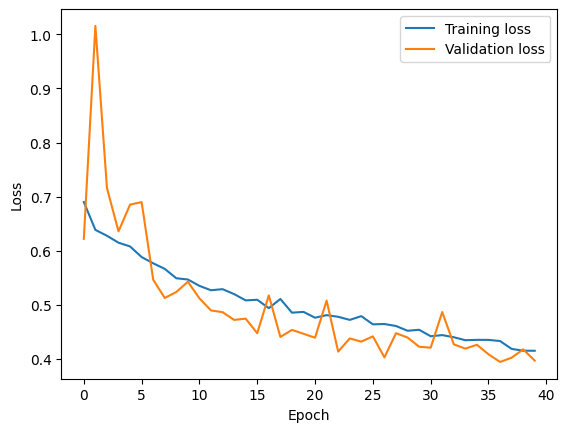

In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f1, f3_in, f3_out, f3dbl_in, f3dbl_out, fpool_out):
        super(InceptionModule, self).__init__()

        # 1x1 conv
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=1),
            nn.BatchNorm2d(f1,momentum=0.9),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, f3_in, kernel_size=1),
            nn.Conv2d(f3_in, f3_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(f3_out,momentum=0.9),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv -> 3x3 conv (replacing the 5x5 conv)
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, f3dbl_in, kernel_size=1),
            nn.Conv2d(f3dbl_in, f3dbl_out, kernel_size=3, padding=1),
            nn.Conv2d(f3dbl_out, f3dbl_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(f3dbl_out,momentum=0.9),
            nn.ReLU(inplace=True)
        )

        # 3x3 maxpool -> 1x1 conv
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, fpool_out, kernel_size=1),
            nn.BatchNorm2d(fpool_out,momentum=0.9),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)
        # Concatenate along the channel axis
        outputs = torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], dim=1)
        return outputs


# Define the full Inception network for binary classification
class InceptionNet(nn.Module):
    def __init__(self):
        super(InceptionNet, self).__init__()
        # Initial convolution layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        # Fully connected layers for binary classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc = nn.Linear(480, 1)  # Output is a single value for binary classification (sigmoid)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)  # Global average pooling
        x = torch.flatten(x, 1)
        x = F.dropout(x, p=0.5)
        x = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        return x

# Instantiate the model, loss function, and optimizer
model = InceptionNet()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if USE_LOCAL_MODEL:
    # Load the pre-trained weights
    model.load_state_dict(torch.load(f'{home_dir}/inception_net.pth'))  # Update with the desired path
    model.eval()
    model.to(device)
else:
    # Training loop
    epochs = 40
    model = model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            outputs = outputs.view(-1)  # Reshape to match labels shape
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.float().to(device)

                val_outputs = model(val_images)
                val_outputs = val_outputs.view(-1)  # Reshape to match labels shape
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                predicted = (val_outputs > 0.5).float()
                correct += (predicted == val_labels).sum().item()
                total += val_labels.size(0)

        val_loss = val_loss / len(test_loader)
        best_val_loss = min(best_val_loss, val_loss)
        if val_loss == best_val_loss:
            torch.save(model.state_dict(), f'{home_dir}/inception_net_best.pth')
        val_acc = correct / total
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



    #plot the loss
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Save the trained model
    torch.save(model.state_dict(), f'{home_dir}/inception_net.pth')  # Update with the desired path


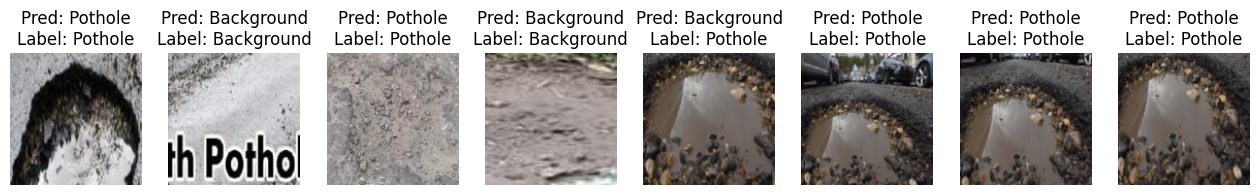

In [169]:
#plot a few predictions
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images
images, labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():    
    images, labels = images.to(device), labels.float().to(device)
    outputs = model(images).to(device)
    predicted = (outputs > 0.5).float()

# Plot the images in the batch, along with the corresponding labels and ground truth
fig, axs = plt.subplots(1, 8, figsize=(16, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f"Pred: {'Pothole' if predicted[i] == 1 else 'Background'}\nLabel: {'Pothole' if labels[i] == 1 else 'Background'}")

plt.show()

In [170]:
# Calculate the overall accuracy on the test set
correct = 0
correct_potholes = 0
correct_background = 0
total_potholes = 0
total_background = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        
        # Ensure outputs are in the correct shape and type
        outputs = outputs.squeeze()  # Remove any extra dimensions
        predicted = (outputs > 0.5).float()
        
        # Flatten predicted and labels to 1D tensors
        predicted = predicted.view(-1)
        labels = labels.view(-1)
        
        total += labels.size(0)
        correct_batch = (predicted == labels).sum().item()
        correct += correct_batch

        #accuracy per class
        correct_potholes += ((predicted == 1) & (labels == 1)).sum().item()
        correct_background += ((predicted == 0) & (labels == 0)).sum().item()

        total_potholes += (labels == 1).sum().item()
        total_background += (labels == 0).sum().item()        
    
accuracy = correct / total
print(f"Number of correct predictions: {correct}/{total}")
print(f"Accuracy: {accuracy}")
print(f"Pothole Accuracy: {correct_potholes / total_potholes}")
print(f"Background Accuracy: {correct_background / total_background}")

Number of correct predictions: 1076/1304
Accuracy: 0.8251533742331288
Pothole Accuracy: 0.8911042944785276
Background Accuracy: 0.75920245398773


In [171]:
#measure AP 
from sklearn.metrics import average_precision_score

# Get the predictions and labels for the test set
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        
        # Ensure outputs are in the correct shape and type
        outputs = outputs.squeeze()  # Remove any extra dimensions
        predicted = outputs.cpu().numpy()
        
        # Flatten predicted and labels to 1D tensors
        labels = labels.cpu().numpy()
        
        all_predictions.extend(predicted)
        all_labels.extend(labels)

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate the average precision
ap = average_precision_score(all_labels, all_predictions)
print(f"Average Precision: {ap:.4f}")

Average Precision: 0.8873
